<a href="https://colab.research.google.com/github/chaleezj/TA-S1-/blob/main/DATA_KAGGLE_TA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Proses Klasifikasi Genus Anggrek Menggunakan CNN (ResNet50)

Data yang digunakan merupakan Data Campuran melalui Internet ( Kaggle) dan Pemotretan secara mandiri.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## proses meng clahe citra

In [ ]:
import cv2
import os
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path dataset (pastikan path sesuai dengan struktur folder kamu)
input_folder = "/content/drive/My Drive/SKRIPSI/dataset_kaggle/"
output_folder = "/content/drive/My Drive/SKRIPSI/dataset_kaggle_clahe/"

# Pastikan folder output ada
os.makedirs(output_folder, exist_ok=True)

# Fungsi CLAHE untuk gambar berwarna
def apply_clahe_rgb(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"⚠️ Gagal membaca gambar: {image_path}")
        return None

    # Konversi ke LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Terapkan CLAHE ke channel L
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    # Gabungkan kembali LAB dan ubah ke BGR
    lab_clahe = cv2.merge((cl, a, b))
    final_img = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    return final_img

# Loop semua subfolder
processed_count = 0

for category in os.listdir(input_folder):  # Loop setiap kategori (Cattleya, Dendrobium, dll.)
    category_path = os.path.join(input_folder, category)

    if os.path.isdir(category_path):  # Pastikan ini folder, bukan file lain
        print(f"\n📂 Memproses kategori: {category}")

        # Buat folder kategori di output
        output_category_path = os.path.join(output_folder, category)
        os.makedirs(output_category_path, exist_ok=True)

        # Loop semua gambar dalam kategori
        for filename in os.listdir(category_path):
            if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                input_path = os.path.join(category_path, filename)
                output_path = os.path.join(output_category_path, filename)

                print(f"🖼 Memproses: {filename}")

                # Terapkan CLAHE
                equalized_img = apply_clahe_rgb(input_path)

                if equalized_img is not None:
                    success = cv2.imwrite(output_path, equalized_img)
                    if success:
                        print(f"✅ Berhasil menyimpan: {output_path}")
                        processed_count += 1
                    else:
                        print(f"❌ Gagal menyimpan: {output_path}")
                else:
                    print(f"❌ Gagal memproses: {input_path}")

print(f"\n🎉 Proses CLAHE selesai! {processed_count} gambar berhasil diproses.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📂 Memproses kategori: Cattleya
🖼 Memproses: 109.spc_000009181_000036040.jpg
✅ Berhasil menyimpan: /content/drive/My Drive/SKRIPSI/dataset_kaggle_clahe/Cattleya/109.spc_000009181_000036040.jpg
🖼 Memproses: 105.cattleya-orchid-flower.jpg
✅ Berhasil menyimpan: /content/drive/My Drive/SKRIPSI/dataset_kaggle_clahe/Cattleya/105.cattleya-orchid-flower.jpg
🖼 Memproses: 102.cattleya-orchids--sophronitis-coccinea--135588646-59777704d963ac00106bef9e.jpg
✅ Berhasil menyimpan: /content/drive/My Drive/SKRIPSI/dataset_kaggle_clahe/Cattleya/102.cattleya-orchids--sophronitis-coccinea--135588646-59777704d963ac00106bef9e.jpg
🖼 Memproses: 103.Cattleya-skinneri-750x500.jpg
✅ Berhasil menyimpan: /content/drive/My Drive/SKRIPSI/dataset_kaggle_clahe/Cattleya/103.Cattleya-skinneri-750x500.jpg
🖼 Memproses: 110.orchid-cattleya-mossia-vestalis_a-G-2910219-9664571.jpg
✅ Berhasil menyimp

## split data

In [ ]:
from sklearn.model_selection import train_test_split
import shutil

# Path ke dataset utama
dataset_path = "/content/drive/My Drive/SKRIPSI/dataset_kaggle_clahe"

# List semua gambar dan labelnya
all_images = []
all_labels = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            all_images.append(os.path.join(class_path, img_name))
            all_labels.append(class_name)

# Split dataset (70% train, 20% valid, 10% test)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(all_images, all_labels, test_size=0.3, stratify=all_labels)
valid_imgs, test_imgs, valid_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=1/3, stratify=temp_labels)

# Fungsi untuk memindahkan file ke folder baru
def move_files(image_list, labels, destination_folder):
    for img_path, label in zip(image_list, labels):
        dest_folder = os.path.join(destination_folder, label)
        os.makedirs(dest_folder, exist_ok=True)
        shutil.copy(img_path, dest_folder)

# Tentukan folder tujuan
train_dir = "/content/drive/My Drive/SKRIPSI/dataset_kaggle_split/train"
valid_dir = "/content/drive/My Drive/SKRIPSI/dataset_kaggle_split/valid"
test_dir = "/content/drive/My Drive/SKRIPSI/dataset_kaggle_split/test"

# Pindahkan file sesuai split
move_files(train_imgs, train_labels, train_dir)
move_files(valid_imgs, valid_labels, valid_dir)
move_files(test_imgs, test_labels, test_dir)

print("Dataset berhasil dipisah ke folder train, valid, dan test.")


Dataset berhasil dipisah ke folder train, valid, dan test.


## augmentasi

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Augmentasi Data
train_datagen = ImageDataGenerator(
     preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.8, 1.2),  # Tambahan agar model lebih tahan terhadap pencahayaan berbeda
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "/content/drive/My Drive/SKRIPSI/dataset_kaggle_split/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True  # Pindahkan ke dalam parameter
)

valid_generator = valid_datagen.flow_from_directory(
    "/content/drive/My Drive/SKRIPSI/dataset_kaggle_split/valid",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Validasi tidak perlu shuffle
)

test_generator = test_datagen.flow_from_directory(
    "/content/drive/My Drive/SKRIPSI/dataset_kaggle_split/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Perbaiki jika ada kesalahan kapitalisasi atau sintaks
)

Found 1132 images belonging to 5 classes.
Found 324 images belonging to 5 classes.
Found 162 images belonging to 5 classes.


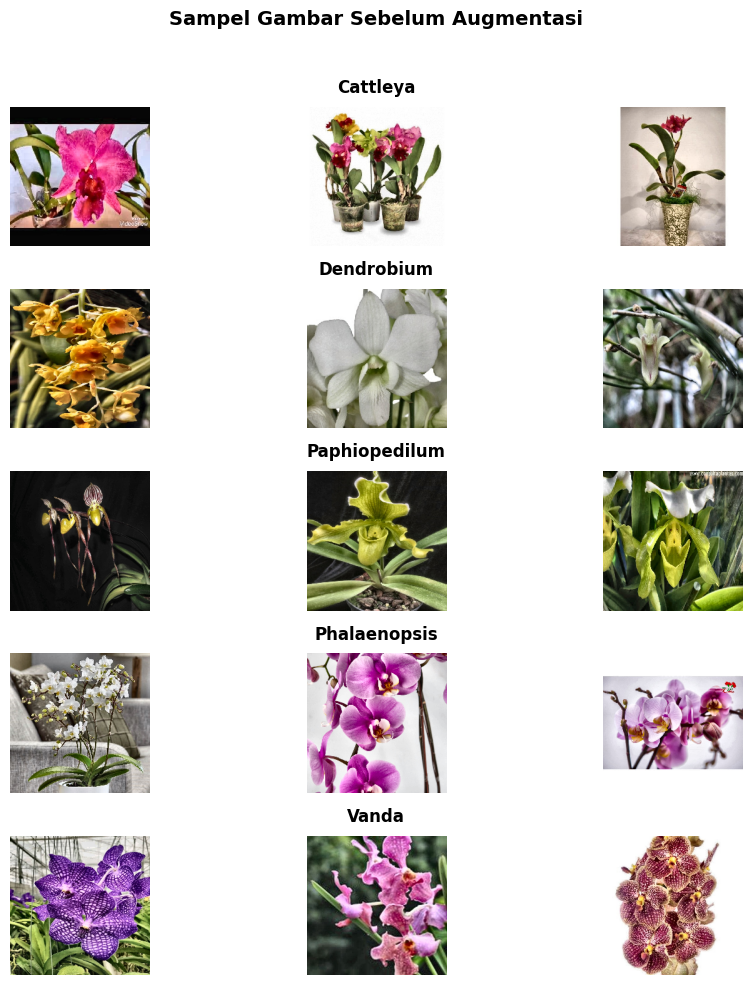

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path ke dataset asli
data_mentah_path = "/content/drive/MyDrive/SKRIPSI/dataset_kaggle_clahe"

# Dapatkan daftar kelas (folder dalam dataset)
class_names = sorted(os.listdir(data_mentah_path))

# Jumlah kelas dan jumlah sample per kelas
num_classes = len(class_names)
samples_per_class = 3  # Menampilkan 3 sampel per kelas

# Buat figure untuk menampilkan gambar per kelas
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(10, num_classes * 2))
fig.suptitle("Sampel Gambar Sebelum Augmentasi", fontsize=14, fontweight="bold")

for i, class_name in enumerate(class_names):
    class_path = os.path.join(data_mentah_path, class_name)
    image_files = sorted(os.listdir(class_path))[:samples_per_class]  # Ambil 3 gambar pertama

    # Tambahkan judul di tengah atas per kelas
    mid_col = samples_per_class // 2
    axes[i, mid_col].set_title(class_name, fontsize=12, fontweight="bold", pad=10)

    for j, image_file in enumerate(image_files):
        img_path = os.path.join(class_path, image_file)
        img = load_img(img_path, target_size=(224, 224))  # Load dan resize gambar
        img_array = img_to_array(img) / 255.0  # Normalisasi untuk ditampilkan

        axes[i, j].imshow(img_array, cmap="gray")  # Gunakan cmap="gray" untuk grayscale
        axes[i, j].axis("off")  # Hilangkan sumbu

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Sesuaikan tata letak agar judul utama terlihat
plt.show()


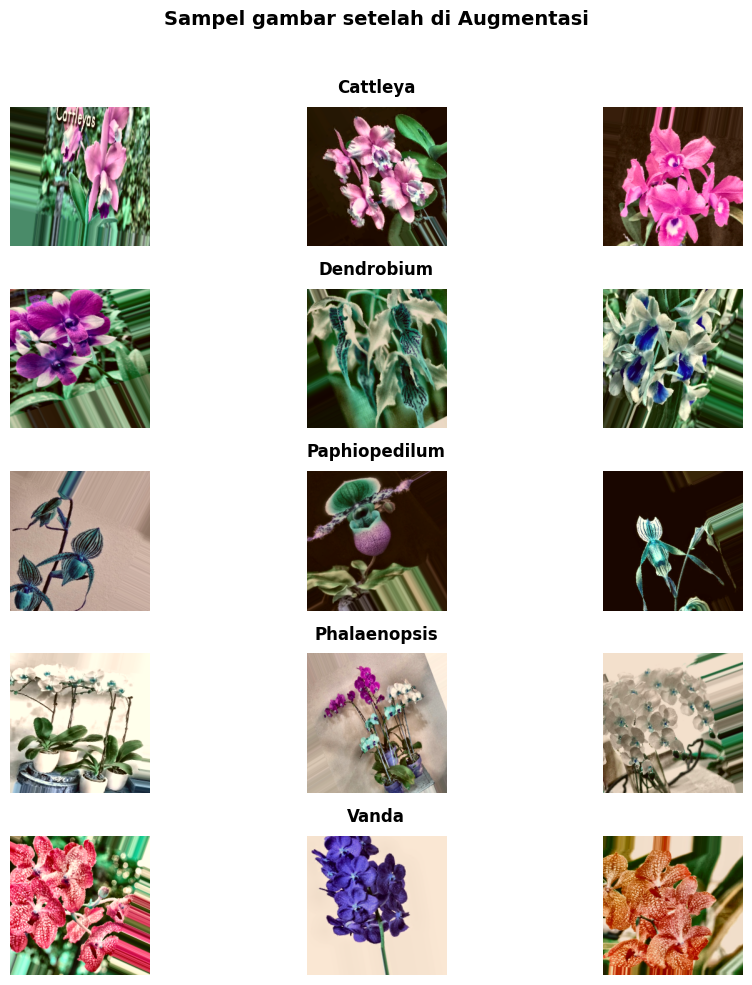

In [ ]:
# Ambil satu batch dari train_generator
sample_batch, labels = next(train_generator)

# Kembalikan gambar ke rentang 0–1 agar bisa ditampilkan dengan benar
# Asumsikan jika kamu tidak memakai preprocess_input(), cukup ini saja:
sample_batch_vis = sample_batch.copy()

# Jika kamu pakai preprocess_input dari ResNet50, maka UNDO normalisasinya:
def undo_preprocess_input(img):
    mean = [123.68, 116.779, 103.939]
    img = img.copy()
    img[..., 0] += mean[0]
    img[..., 1] += mean[1]
    img[..., 2] += mean[2]
    return np.clip(img / 255.0, 0, 1)  # Balik ke skala 0–1 untuk imshow

# Jika kamu pakai preprocess_input(), pakai ini untuk visualisasi:
sample_batch_vis = np.array([undo_preprocess_input(img) for img in sample_batch])

# Mendapatkan daftar nama kelas dari train_generator
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Tentukan jumlah kelas dan jumlah sample per kelas
num_classes = len(class_names)
samples_per_class = 3

# Buat figure untuk menampilkan gambar per genus
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(10, num_classes * 2))
fig.suptitle("Sampel gambar setelah di Augmentasi", fontsize=14, fontweight="bold")

# Loop per kelas
for i in range(num_classes):
    class_idx = np.argmax(labels, axis=1)
    sample_idx = np.where(class_idx == i)[0]

    mid_col = samples_per_class // 2
    axes[i, mid_col].set_title(class_names[i], fontsize=12, fontweight="bold", pad=10)

    for j in range(samples_per_class):
        if j < len(sample_idx):
            axes[i, j].imshow(sample_batch_vis[sample_idx[j]])
        axes[i, j].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
print(train_generator.class_indices)  # Mengecek mapping label ke indeks
print(train_generator.samples)        # Mengecek jumlah sample di training set
print(valid_generator.samples)        # Mengecek jumlah sample di validation set
print(test_generator.samples)         # Mengecek jumlah sample di test set

{'Cattleya': 0, 'Dendrobium': 1, 'Paphiopedilum': 2, 'Phalaenopsis': 3, 'Vanda': 4}
1132
324
162


## Modeling

In [ ]:
# Load model ResNet50 tanpa fully connected layer (include_top=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
base_model.trainable = False  # Freeze all layers

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import CategoricalAccuracy

# Custom Model
# Custom Model
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)  # Kurangi regulasi L2 dari 1e-4 ke 1e-5
x = Dropout(0.3)(x)  # Kurangi dropout dari 0.5 ke 0.3
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)  # Kurangi dropout dari 0.4 ke 0.3
output = Dense(5, activation='softmax')(x)

In [ ]:
# Buat model akhir
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Optimizer dengan learning rate dinamis
optimizer = Adam(learning_rate=1e-4)

In [ ]:
# Compile Model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Callback untuk mengurangi learning rate jika val_loss stagnan
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Callback untuk menyimpan model terbaik berdasarkan val_loss terendah
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Callback untuk menghentikan training jika val_loss tidak membaik setelah beberapa epoch
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

# Masukkan callback ke dalam list
callbacks = [reduce_lr, model_checkpoint, early_stopping]

## training model

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Callback untuk mengurangi learning rate jika val_loss stagnan
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Callback untuk menyimpan model terbaik berdasarkan val_loss terendah
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Callback untuk menghentikan training jika val_loss tidak membaik setelah beberapa epoch
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)


In [ ]:
# Training Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=35,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.3038 - loss: 2.1465 
Epoch 1: val_loss improved from inf to 1.28686, saving model to best_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 938s 26s/step - accuracy: 0.3053 - loss: 2.1430 - val_accuracy: 0.5309 - val_loss: 1.2869 - learning_rate: 1.0000e-04
Epoch 2/35
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.5328 - loss: 1.4095
Epoch 2: val_loss improved from 1.28686 to 1.09144, saving model to best_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 610ms/step - accuracy: 0.5328 - loss: 1.4110 - val_accuracy: 0.6296 - val_loss: 1.0914 - learning_rate: 1.0000e-04
Epoch 3/35
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6190 - loss: 1.1718
Epoch 3: val_loss improved from 1.09144 to 0.99522, saving model to best_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 616ms/step - accuracy: 0.6187 - loss: 1.1734 - val_accuracy: 0.6698 - val_loss: 0.9952 - learning_rate: 1.0000e-04
Epoch 4/35
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - a

## mengaktifkan fine tunning

In [ ]:
# 1. Load ulang Data Generator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)

train_generator = train_datagen.flow_from_directory(
    "/content/drive/My Drive/SKRIPSI/dataset_kaggle_split/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    "/content/drive/My Drive/SKRIPSI/dataset_kaggle_split/valid",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1132 images belonging to 5 classes.
Found 324 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.models import load_model

# Load model terbaik setelah pretraining
model = load_model('best_model.keras')


In [ ]:
# 1️⃣ Unfreeze 30 layer terakhir saja
for layer in model.layers[:-20]:
    layer.trainable = False

* menambahkan layer tambahan di atas model pretrained dengan teknik regularisasi seperti BatchNormalization, Dropout, dan L2 Regularization untuk mencegah overfitting.
* Kecepatan pembelajaran kecil digunakan saat fine-tuning agar model bisa belajar lebih stabil tanpa merusak bobot model yang telah dilatih sebelumnya.

In [ ]:
from tensorflow.keras.layers import BatchNormalization

for layer in model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

In [ ]:
# 3️⃣ Compile dengan SGD + Momentum
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler

# Callback untuk menurunkan learning rate jika val_loss tidak membaik dalam 2 epoch
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Callback untuk early stopping jika val_loss tidak membaik dalam 5 epoch
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

# Callback untuk menyimpan model terbaik dalam format .keras
checkpoint = ModelCheckpoint('best_finetuned_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Perbaiki perhitungan steps_per_epoch agar tidak terjadi kehabisan data
steps_per_epoch = len(train_generator)  # Langsung ambil jumlah batch
validation_steps = len(valid_generator)  # Sama untuk validasi

# Pastikan generator training di-shuffle agar tidak kehabisan data lebih cepat
train_generator = train_datagen.flow_from_directory(
    "/content/drive/My Drive/SKRIPSI/dataset_kaggle_split/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True  # HARUS diaktifkan di sini, bukan setelahnya
)

valid_generator = valid_datagen.flow_from_directory(
    "/content/drive/My Drive/SKRIPSI/dataset_kaggle_split/valid",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Validasi tidak perlu shuffle
)

# Cosine Annealing Learning Rate
def cosine_annealing(epoch, lr_max=1e-4, lr_min=1e-6, T_max=20):
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + np.cos(epoch / T_max * np.pi))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)


# 6️⃣ Training dengan Fine-Tuning
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=[lr_scheduler, reduce_lr]  # Gunakan scheduler dan ReduceLROnPlateau
)

# Muat ulang model terbaik setelah training selesai
best_model = tf.keras.models.load_model('best_model.keras')

# Evaluasi model terbaik pada data validasi
val_loss, val_acc = best_model.evaluate(valid_generator)
print(f"Final Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

Found 1132 images belonging to 5 classes.
Found 324 images belonging to 5 classes.
Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 62s 829ms/step - accuracy: 0.8593 - loss: 0.5099 - val_accuracy: 0.8025 - val_loss: 0.7373 - learning_rate: 1.0000e-05
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 309ms/step - accuracy: 0.9251 - loss: 0.3350 - val_accuracy: 0.8148 - val_loss: 0.7147 - learning_rate: 9.9446e-06
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 312ms/step - accuracy: 0.9232 - loss: 0.3392 - val_accuracy: 0.8056 - val_loss: 0.7047 - learning_rate: 9.7257e-06
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - accuracy: 0.9566 - loss: 0.2334 - val_accuracy: 0.8148 - val_loss: 0.6506 - learning_rate: 9.2502e-06
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 315ms/step - accuracy: 0.9718 - loss: 0.2053 - val_accuracy: 0.8241 - val_loss: 0.6787 - learning_rate: 8.4624e-06
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 307ms/step - accuracy: 0.9847 - loss: 0.1755 - val_accuracy: 0.8241 - val_loss: 0.6822 - l

In [ ]:
# 1️⃣ Load model terbaik tahap 1
model = tf.keras.models.load_model('best_model.keras')

# 2️⃣ Unfreeze hanya 20 layer terakhir
for layer in model.layers[-30:]:
    layer.trainable = True

# 3️⃣ Compile ulang model dengan learning rate kecil
from tensorflow.keras.optimizers import Adam

fine_tune_lr = 5e-6  # lebih kecil untuk aman

model.compile(
    optimizer=Adam(learning_rate=fine_tune_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4️⃣ Callback
fine_tune_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
fine_tune_early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
fine_tune_checkpoint = ModelCheckpoint('best_finetuned_model_stage2.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# 5️⃣ Training ulang Fine-Tuning Tahap 2
fine_tune_epochs = 10

history_fine_tune2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=fine_tune_epochs,
    callbacks=[fine_tune_reduce_lr, fine_tune_early_stop, fine_tune_checkpoint],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

# 6️⃣ Load model terbaik dari Fine-Tuning Tahap 2
best_model_stage2 = tf.keras.models.load_model('best_finetuned_model_stage2.keras')

# 7️⃣ Evaluasi
val_loss, val_acc = best_model_stage2.evaluate(valid_generator)
print(f"Stage 2 Final Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8697 - loss: 0.4843
Epoch 1: val_loss improved from inf to 0.72987, saving model to best_finetuned_model_stage2.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 609ms/step - accuracy: 0.8695 - loss: 0.4848 - val_accuracy: 0.7901 - val_loss: 0.7299 - learning_rate: 5.0000e-06
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8781 - loss: 0.4371
Epoch 2: val_loss improved from 0.72987 to 0.71925, saving model to best_finetuned_model_stage2.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 298ms/step - accuracy: 0.8783 - loss: 0.4372 - val_accuracy: 0.7932 - val_loss: 0.7192 - learning_rate: 5.0000e-06
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8715 - loss: 0.4483
Epoch 3: val_loss improved from 0.71925 to 0.71096, saving model to best_finetuned_model_stage2.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 296ms/step - accuracy: 0.8718 - loss: 0.4478 - val_accuracy: 0.7932 - val_loss: 0.7110 - learning_rate: 5.0000e-06
Ep

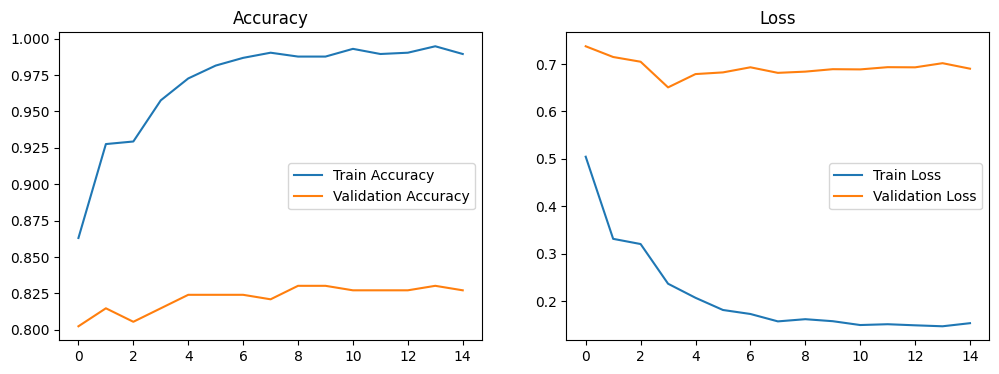

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [ ]:
loss, accuracy = model.evaluate(valid_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.8282 - loss: 0.6556
Validation Loss: 0.6901
Validation Accuracy: 0.8272


In [ ]:
test_generator = test_datagen.flow_from_directory(
    "/content/drive/My Drive/SKRIPSI/dataset_split/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
print("Class indices:", test_generator.class_indices)
print("Total samples in test generator:", test_generator.samples)


Found 259 images belonging to 5 classes.
Class indices: {'Cattleya': 0, 'Dendrobium': 1, 'Paphiopedilum': 2, 'Phalaenopsis': 3, 'Vanda': 4}
Total samples in test generator: 259


In [ ]:
# Evaluasi model dengan data testing
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 160s 20s/step - accuracy: 0.8590 - loss: 0.5485
Test Accuracy: 0.8456
Test Loss: 0.6324


In [ ]:
print("Distribusi Label Ground Truth:", np.bincount(test_generator.classes))

Distribusi Label Ground Truth: [52 52 52 52 51]


In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
print("Distribusi Prediksi Model:", np.bincount(predicted_classes))


9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
Distribusi Prediksi Model: [55 33 56 70 45]


In [ ]:
import os
test_path = "/content/drive/My Drive/SKRIPSI/dataset_split/test"
for class_name in os.listdir(test_path):
    print(f"{class_name}: {len(os.listdir(os.path.join(test_path, class_name)))} images")


Dendrobium: 52 images
Paphiopedilum: 52 images
Vanda: 51 images
Cattleya: 52 images
Phalaenopsis: 52 images


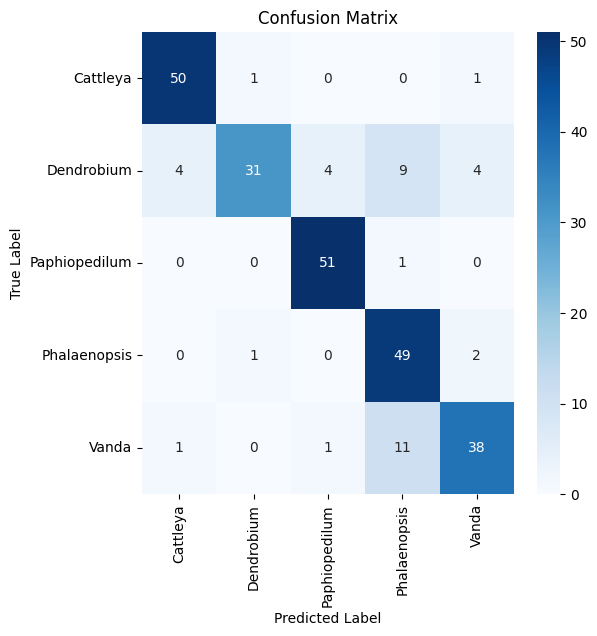

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_generator.classes, predicted_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, predicted_classes, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

     Cattleya       0.91      0.96      0.93        52
   Dendrobium       0.94      0.60      0.73        52
Paphiopedilum       0.91      0.98      0.94        52
 Phalaenopsis       0.70      0.94      0.80        52
        Vanda       0.84      0.75      0.79        51

     accuracy                           0.85       259
    macro avg       0.86      0.85      0.84       259
 weighted avg       0.86      0.85      0.84       259



9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


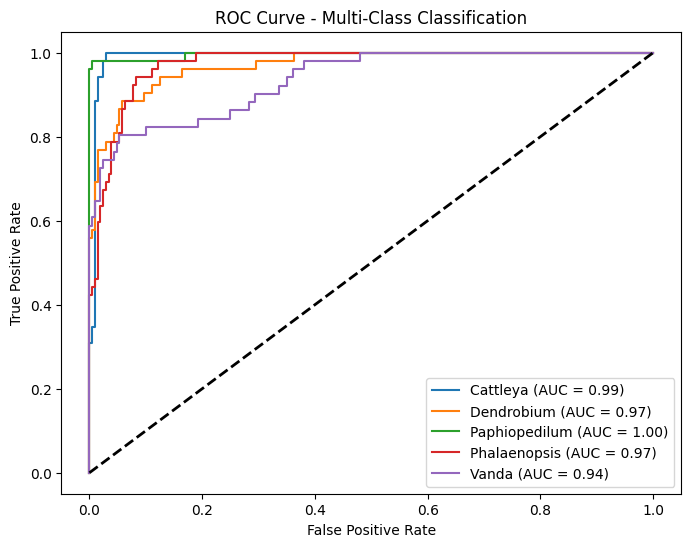

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Ambil jumlah kelas dari test generator
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)

# One-hot encode label asli (ground truth)
y_test_bin = label_binarize(test_generator.classes, classes=np.arange(n_classes))

# Ambil probabilitas prediksi dari model (bukan kelas prediksi langsung)
y_pred_proba = model.predict(test_generator)

# Plot ROC Curve untuk setiap kelas
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

# Tambahkan garis diagonal sebagai referensi
plt.plot([0, 1], [0, 1], "k--", lw=2)

# Label dan judul grafik
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()
